# Bayesian Regression

In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.stats import multivariate_normal
import textwrap
import math
%matplotlib inline  


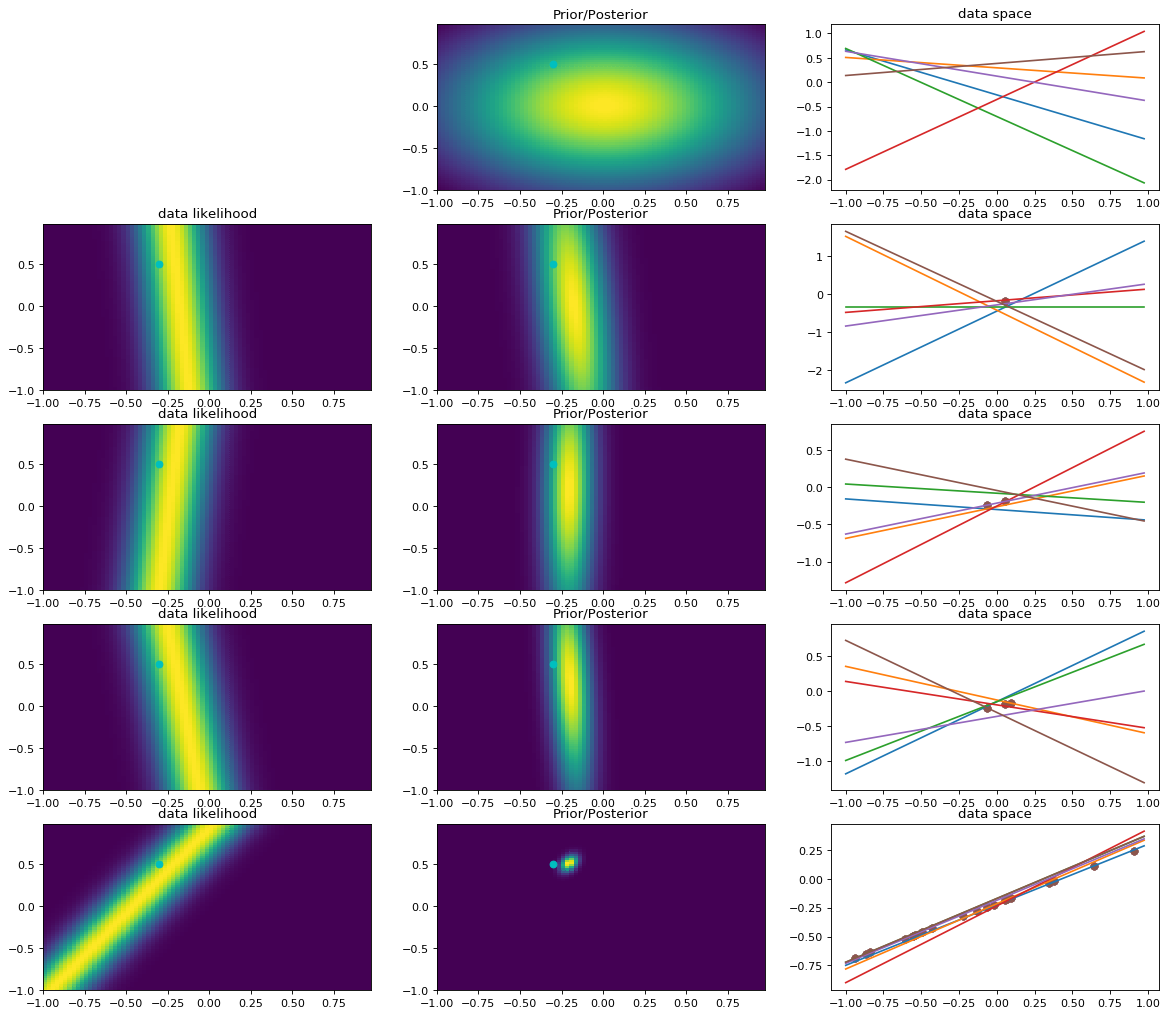

In [4]:
def likelihood_prior_func():   
    fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

    #set up variables
    a = -0.3
    b = 0.5
    rangeX = [-1, 1]
    step = 0.025
    X = np.mgrid[rangeX[0]:rangeX[1]:step]
    alpha = 2
    beta = 50
    S0 = (1/alpha)*np.eye(2)
    draw_num = (0,1,2,3,20)

    #initialize prior/posterior and sample data
    sigma = S0
    mean = [0,0]
    draws = np.random.uniform(rangeX[0],rangeX[1],size=draw_num[-1])
    T = a + b*draws + np.random.normal(loc=0, scale=math.sqrt(1/beta))

    for i in range(len(draw_num)):
        if draw_num[i]>0: #skip first image
            #Show data likelihood
            Phi = np.vstack((np.ones(draws[0:draw_num[i]].shape), draws[0:draw_num[i]]))
            t = T[0:draw_num[i]]
            sigma = np.linalg.inv(S0 + beta*Phi@Phi.T)
            mean = beta*sigma@Phi@t

            w0, w1 = np.mgrid[rangeX[0]:rangeX[1]:step, rangeX[0]:rangeX[1]:step]
            p = multivariate_normal(t[draw_num[i]-1], 1/beta)
            out = np.empty(w0.shape)
            for j in range(len(w0)):
                out[j] = p.pdf(w0[j]+w1[j]*draws[draw_num[i]-1])

            ax = fig.add_subplot(*[len(draw_num),3,(i)*3+1])
            ax.pcolor(w0, w1, out)
            ax.scatter(a,b, c='c')
            myTitle = 'data likelihood'
            ax.set_title("\n".join(textwrap.wrap(myTitle, 100)))

        #Show prior/posterior
        w0, w1 = np.mgrid[rangeX[0]:rangeX[1]:step, rangeX[0]:rangeX[1]:step]
        pos = np.empty(w1.shape + (2,))
        pos[:, :, 0] = w0; pos[:, :, 1] = w1
        p = multivariate_normal(mean, sigma)

        ax = fig.add_subplot(*[len(draw_num),3,(i)*3+2])
        ax.pcolor(w0, w1, p.pdf(pos))
        ax.scatter(a,b, c='c')
        myTitle = 'Prior/Posterior'
        ax.set_title("\n".join(textwrap.wrap(myTitle, 100)))

        #Show data space
        for j in range(6):
            w0, w1 = np.random.multivariate_normal(mean, sigma)
            t = w0 + w1*X
            ax = fig.add_subplot(*[len(draw_num),3,(i)*3+3])
            ax.plot(X,t)
            if draw_num[i] > 0:
                ax.scatter(Phi[1,:], T[0:draw_num[i]])
            myTitle = 'data space'
            ax.set_title("\n".join(textwrap.wrap(myTitle, 100)))

    plt.show()

likelihood_prior_func()


In [5]:
def generateRandData(N, l, u, gVar):
	'''generateRandData(N, l, u, gVar): Generate N uniformly random data points in the range [l,u) with zero-mean Gaussian random noise with variance gVar'''
	x = np.random.uniform(l,u,N)
	e = np.random.normal(0,gVar,N)
	t = np.sin(2*math.pi*x) + e
	return x,t

def pdist1D(X):
	'''pdist1D(X): computes pairwise squared euclidean distance between 1D points stored in a vector X'''
	X = np.matlib.repmat(X, X.shape[0], 1);
	D = X-X.T
	return D*D

def computePhi(X, s=1): #compute basis function
	'''computePhi(X, s)'''
	D = pdist1D(X)
	phi = np.exp(-0.5*D/s)
	return phi

	return 0

def fig3_8(data, t, s, beta, alpha, m0, pltrange):
	'''Recreate Figure 3_8 from the Bishop text.'''


	# Compute Phi (i.e., put training data through basis functions)
	phi = computePhi(data, s)

	# Compute posterior mean, mn, and covariance, Sn
	Sn = alpha*np.eye(data.shape[0]) + beta*phi.T@phi
	mn = beta*np.linalg.inv(Sn)@phi.T@t.T

	# Plot everything
	xx =  np.arange(pltrange[0],pltrange[1],0.01);
	mx = [mn.T@(np.exp(-0.5*(i-data)*(i-data)/s)).T for i in xx]
	sx = [(1/beta)+np.exp(-0.5*(i-data)*(i-data)/s)@np.linalg.inv(Sn)@np.exp(-0.5*(i-data)*(i-data)/s).T for i in xx]
	fig = plt.figure()
	plt.errorbar( xx, mx, sx, linewidth=5, alpha=0.1)
	plt.plot( xx, mx, c='r')
	plt.plot( xx, [math.sin(2*math.pi*i) for i in xx], c='b')
	plt.scatter(data, t, linewidth=3)
	ymin = min(np.hstack((mx-np.sqrt(sx)-1, [np.sin(2*math.pi*i) for i in xx])))
	ymax = max(mx+np.sqrt(sx)+1)
	yy = np.arange(ymin,ymax,0.01)
	for i in range(data.shape[0]):
		yx = data[i]*np.ones(yy.shape)
		plt.plot(yx,yy,c='g',linewidth=1)

	plt.axis([pltrange[0], pltrange[1], ymin, ymax])
	plt.show()

def fig3_9(s, beta, alpha, m0, pltrange):
	'''Recreate figure 3.9 from the Bishop textbook'''

	numPoints = [1,2,4,25]
	numSamples = 5

	for nP in range(4):
		[data, t] = generateRandData(numPoints[nP], 0, 1, 1/beta)
		phi = computePhi(data, s)
		# Compute posterior mean, mn, and covariance, Sn
		Sn = alpha*np.eye(data.shape[0]) + beta*phi.T@phi
		mn = beta*np.linalg.inv(Sn)@phi.T@t.T

		weights = np.random.multivariate_normal(mn,np.linalg.inv(Sn),numSamples)
		xx =  np.arange(pltrange[0],pltrange[1],0.01)
		for j in range(numSamples):
			mx =  [weights[j,:].T@(np.exp(-0.5*(i-data)*(i-data)/s)).T for i in xx]
			plt.subplot(*[2,2,nP+1])
			plt.plot(xx,mx,c = 'r')
			plt.scatter(data, t, linewidth=3)
	# plt.show()
	plt.savefig('fig3_9.pdf') 

    

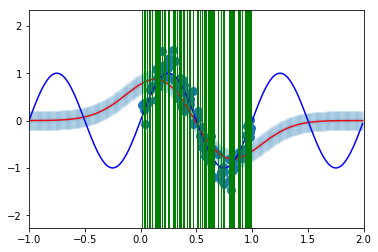

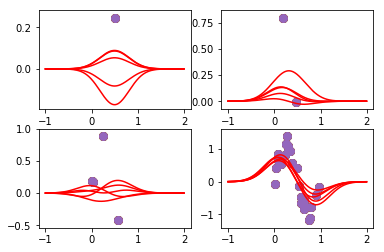

In [28]:
# set parameters
s = 0.1 #variance parameter for RBFs
beta = 5 #noise precision: larger precision, smaller variance
alpha = 100 #prior precision
m0 = 1 #prior mean
numPoints = 100 #number of training points
pltrange = [-1,2]

#generate training data
[data, t] = generateRandData(numPoints, 0, 1, 1/beta)
fig3_8(data, t, s, beta, alpha, m0, pltrange)
fig3_9(s, beta, alpha, m0, pltrange)